In [1]:
import functools
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64

# Resources for learning TFP
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/NoUTurnSampler
# https://www.tensorflow.org/probability/overview
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc
# https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution
# https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model

# To better understand event_shape, batch_shape, sample_shape:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution
# https://www.youtube.com/watch?v=zWXTpZX4PPo

In [2]:
# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
def stickbreak(v):
    cumprod_one_minus_v = tf.math.cumprod(1 - v)
    one_v = tf.pad(v, [[0, 1]], "CONSTANT", constant_values=1)
    c_one = tf.pad(cumprod_one_minus_v, [[1, 0]], "CONSTANT", constant_values=1)
    return one_v * c_one 

# Example:
# stickbreak(np.random.rand(3))

In [4]:
# See: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily
# See: https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model
def create_dp_sb_gmm(nobs, K, dtype=np.float64):
    return tfd.JointDistributionNamed(dict(
        # Mixture means
        mu = tfd.Independent(
            tfd.Normal(np.zeros(K, dtype), 3),
            reinterpreted_batch_ndims=1
        ),
        # Mixture scales
        sigma = tfd.Independent(
            tfd.Gamma(concentration=np.ones(K, dtype), rate=10),
            reinterpreted_batch_ndims=1
        ),
        # Mixture weights (stick-breaking construction)
        alpha = tfd.Gamma(concentration=np.float64(1.0), rate=10.0),
        v = lambda alpha: tfd.Independent(
            tfd.Beta(np.ones(K - 1, dtype), alpha),
            reinterpreted_batch_ndims=1
        ),
        # v = tfd.Dirichlet(np.ones(K, dtype) / K),

        # Observations (likelihood)
        obs = lambda mu, sigma, v: tfd.Sample(tfd.MixtureSameFamily(
            # This will be marginalized over.
            mixture_distribution=tfd.Categorical(probs=stickbreak(v)),
            # mixture_distribution=tfd.Categorical(probs=v),
            components_distribution=tfd.Normal(mu, sigma)),
            sample_shape=nobs)
    ))

In [5]:
# print(dp_sb_gmm.resolve_graph())
dp_sb_gmm = create_dp_sb_gmm(13, 5)
sample = dp_sb_gmm.sample()
dp_sb_gmm.log_prob(**sample)
# sample

<tf.Tensor: shape=(), dtype=float64, numpy=33.13485351373168>

In [6]:
sample

{'alpha': <tf.Tensor: shape=(), dtype=float64, numpy=0.11010404529319917>,
 'v': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.99760174, 0.9974451 , 0.99926979, 0.89279289])>,
 'sigma': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.03200257, 0.0227029 , 0.21559201, 0.13263577, 0.01384751])>,
 'mu': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([-1.27072542, -5.43054083,  0.92152115, -1.65020006,  1.21409476])>,
 'obs': <tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([-1.34979626, -1.27159249, -1.21695313, -1.28304561, -1.25518474,
        -1.25524588, -1.2920364 , -1.26977296, -1.2632391 , -1.31680706,
        -1.24676002, -1.27354939, -1.27515335])>}

In [7]:
dp_sb_gmm.log_prob(mu=tfd.Normal(np.float64(0), 1).sample(5),
                   sigma=tfd.Uniform(np.float64(0), 1).sample(5),
                   alpha=tf.cast(1, dtype),
                   v=tfd.Beta(np.float64(1), 1).sample(5 - 1),
                   obs=np.random.randn(1000))

<tf.Tensor: shape=(), dtype=float64, numpy=-2088.503938884246>

In [8]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)
    
y = np.array(simdata['y'], np.float64)

In [9]:
%%time 

ncomponents = 10

model = create_dp_sb_gmm(nobs=len(simdata['y']), K=ncomponents)

def joint_log_prob(obs, mu, sigma, alpha, v):
    return model.log_prob(obs=obs, 
                          mu=mu, sigma=sigma,
                          alpha=alpha, v=v)
    
_ = joint_log_prob(y, 
                   np.random.randn(10),
                   np.random.rand(10),
                   np.float64(1),
                   np.random.rand(9))

unnormalized_posterior_log_prob = functools.partial(joint_log_prob, y)

# Create initial state?
initial_state = [
    tf.zeros(ncomponents, dtype, name='mu'),
    tf.ones(ncomponents, dtype, name='sigma'),
    tf.ones([], dtype, name='alpha'),
    tf.fill(ncomponents - 1, value=np.float64(0.9), name='v')
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Sigmoid()
]

# No progress bar?!
@tf.function(autograph=False)
def sample():
    return tfp.mcmc.sample_chain(
        num_results=500,
        num_burnin_steps=500,
        current_state=initial_state,
        kernel=tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                # HMC:
                inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                     target_log_prob_fn=unnormalized_posterior_log_prob,
                     step_size=0.01,
                     num_leapfrog_steps=100),
                # NUTS:
                # inner_kernel=tfp.mcmc.NoUTurnSampler(
                #      target_log_prob_fn=unnormalized_posterior_log_prob,
                #      step_size=0.01, max_tree_depth=10
                # ),
                bijector=bijectors),
             num_adaptation_steps=400),
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

%time [mu, sigma, alpha, v], is_accepted = sample()

In [14]:
def plot_param_post(param, param_name, param_full_name, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

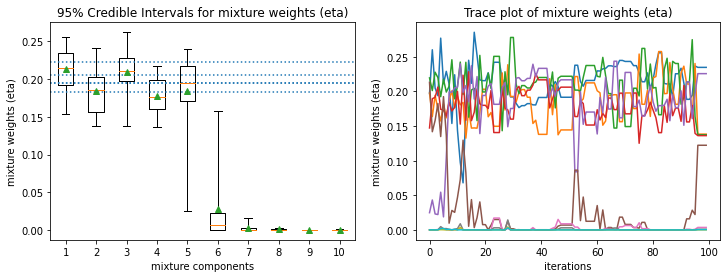

In [16]:
eta = np.apply_along_axis(stickbreak, 1, v)
plot_param_post(eta, 'eta', 'mixture weights (eta)', truth=simdata['w']);

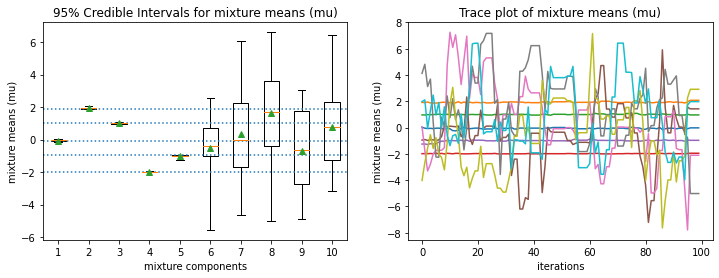

In [18]:
plot_param_post(mu.numpy(), 'mu', 'mixture means (mu)', truth=simdata['mu']);

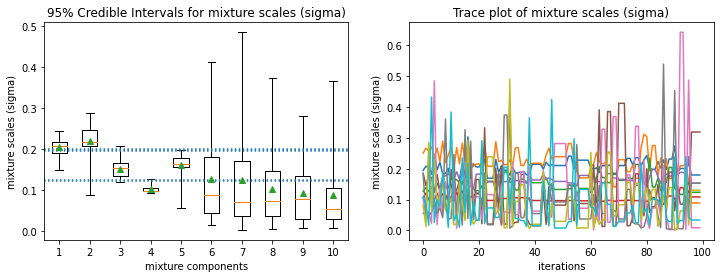

In [20]:
plot_param_post(sigma.numpy(), 'sigma', 'mixture scales (sigma)', truth=simdata['sig']);

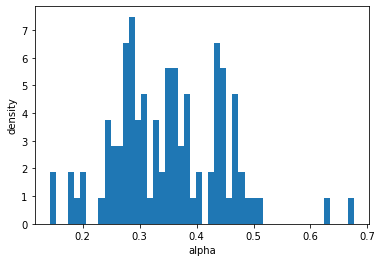

In [22]:
plt.hist(alpha.numpy(), density=True, bins=50)
plt.ylabel('density')
plt.xlabel('alpha');